In [7]:
# The epigenetic clock code in this file is a modified version 
# of the MIT-licensed code by Colin P. Farrell 
# found here: https://github.com/NuttyLogic/MethodsTBS/blob/master/FittingEpigeneticClock.ipynb
# It was modified by Ronan Bennett.
# Here is the MIT License from Colin's original code:
# MIT License

# Copyright (c) 2020 Colin P. Farrell

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn.linear_model
import json
from tqdm.notebook import tqdm
from IPython.display import display

# This code requires a CG methylation matrix from the 9 whole-genome bisulfite sequencing Xenopus samples.
# Filename of the CG matrix:
PILOT_FNAME = 'CGmatrix_5x_100.txt'

def pprint(L):
    for i in L:
        print(i)

def r2(x,y):
    return scipy.stats.pearsonr(x,y)[0] ** 2

def f_linear(x, a, b):
    return a * np.asarray(x) + b

def preprocess_matrix(matrix_fname, parse_sample_fn, name_to_age, variance_threshold=None, truncate_after=None, sep='\t'):
    meth_matrix = pd.read_csv(matrix_fname, sep=sep)  # file taken from /u/m/mmorsell/XenTro/CGmatrix_3x/CGmatrix_5x_100.txt
    if truncate_after:
        meth_matrix = meth_matrix.truncate(after=truncate_after)
    datacols = [parse_sample_fn(col) for col in meth_matrix.columns[1:]]
    # rename every column
    sites_col = meth_matrix['Site']
    meth_matrix.columns = [meth_matrix.columns[0]] + datacols
    datacols.sort(key=lambda x: name_to_age[x])  # sort cols by increasing age
    meth_matrix = meth_matrix[datacols]
    if variance_threshold:
        meth_matrix = meth_matrix.loc[meth_matrix.var(axis=1) >= variance_threshold]
        sites_col = sites_col[meth_matrix.index]
    return meth_matrix, sites_col

def graph_loo(predicted_ages, f_fit, title):
    x = [age[0] for age in predicted_ages.values()] 
    y = [age[1] for age in predicted_ages.values()]
    # fit trend line
    popt, pcov = scipy.optimize.curve_fit(f_fit, x, y)
    rsquared = r2(y, f_fit(x, *popt))
    print(f"R2 {rsquared}")
    
    # format plot label
    plot_label = f'$f(x)={popt[0]:.2f}x + {popt[1]:.2f}, R^{{2}}={rsquared:.2f}$'
    # plot trend line
    xaxis = np.linspace(min(x),max(x))
    #print(xaxis)
    plt.scatter(x,y,color='k',s=6)
    plt.plot(xaxis,f_fit(xaxis,*popt), 'r--', label=plot_label)
    plt.plot(xaxis,xaxis) # y = x line
    
    plt.xlabel('Chronological Age (years)')
    plt.ylabel('Predicted Age (years)')
    plt.legend()
    plt.title(title)
    plt.show()
    

def train(meth_matrix, name_to_age, L1R, ALPHA, MAX_ITER, train_colnames):
    train_ages = [name_to_age[train_colname] for train_colname in train_colnames]
    train_meth_matrix = meth_matrix[train_colnames].values.T  # np array 
    
    lm = sklearn.linear_model.ElasticNet(alpha=ALPHA,l1_ratio=L1R,max_iter=MAX_ITER)
    lm.fit(train_meth_matrix, train_ages)
    return lm
    
# modifies predicted_ages
def test(meth_matrix, name_to_age, lm, predicted_ages, test_colname):
    test_age = name_to_age[test_colname]
    test_meth_matrix = meth_matrix[test_colname].values.reshape(1,-1)  # np array
    predicted_test_age = lm.predict(test_meth_matrix)[0]
    predicted_ages[test_colname] = [test_age, predicted_test_age]
    
# trains and tests clocks, leaving out any sequence of colnames
def clock_leave_out_general(meth_matrix, name_to_age, L1R, ALPHA, MAX_ITER, all_train_colnames, seq_colnames_left_out, save_coefs=False, is_print=False):
    predicted_ages = {}
    if save_coefs:
        saved_coefs = {}

    for colnames_left_out in seq_colnames_left_out:
        # TRAIN
        train_colnames = [i for i in all_train_colnames if i not in colnames_left_out]  # TODO: make more efficient
        lm = train(meth_matrix, name_to_age, L1R, ALPHA, MAX_ITER, train_colnames)
        
        # TEST
        for frog_sample_to_leave_out in colnames_left_out:
            test_colname = frog_sample_to_leave_out
            test(meth_matrix, name_to_age, lm, predicted_ages, test_colname)
            
        if is_print:
            print(f"{colnames_left_out} lm num of params: {len([x for x in lm.coef_ if x != 0. and x != -0.])}")
        if save_coefs:
            saved_coefs[colnames_left_out[0]] = lm.coef_  # only works for LOO
            
    if save_coefs:
        return predicted_ages, saved_coefs
    return predicted_ages

In [8]:
def pilot_parse_sample(col_str):
    for i in range(len(col_str)):
        if col_str[i].isdigit():
            age_index = int(col_str[i:])
            return age_index
        

def test_pilot_loo(fname, is_print=False): 
    pilot_name_to_age = {1:3364./365, 2:3364./365, 3:3364./365,
                       4:1923./365, 5:1900./365, 6:1900./365,
                       7:307./365, 8:307./365, 9:277./365,}
    pilot_matrix, pilot_sites = preprocess_matrix(fname, 
                                                  pilot_parse_sample, pilot_name_to_age, None, 110543, '\t')
    L1R = 0.5
    ALPHA = 0.002836935565702689
    MAX_ITER = 8000
    
    #LOO 
    train_colnames = list(pilot_matrix.columns.values)
    n_samples = len(pilot_matrix.columns)
    seq_colnames_left_out = [[i] for i in range(1,n_samples+1) if i in train_colnames]
    
    pilot_predicted_ages = clock_leave_out_general(pilot_matrix, pilot_name_to_age, L1R, ALPHA, MAX_ITER, train_colnames, seq_colnames_left_out, False, is_print)
    if is_print:
        graph_loo(pilot_predicted_ages, f_linear, "")
    
    pilot_truth_predicted_ages = {1: [9.216438356164383, 7.783452221292768],
     2: [9.216438356164383, 8.488030333159044],
     3: [9.216438356164383, 8.213260993475496],
     4: [5.2684931506849315, 5.122339810188716],
     5: [5.205479452054795, 5.3624004546977915],
     6: [5.205479452054795, 7.246571129584704],
     7: [0.8410958904109589, 1.6630101733112284],
     8: [0.8410958904109589, 2.3946677310871083],
     9: [0.7589041095890411, 1.8900375202592654]}
    return pilot_predicted_ages == pilot_truth_predicted_ages

def test_pilot_full(fname, is_print=False):
    pilot_name_to_age = {1:3364./365, 2:3364./365, 3:3364./365,
                       4:1923./365, 5:1900./365, 6:1900./365,
                       7:307./365, 8:307./365, 9:277./365,}
    pilot_matrix, pilot_sites = preprocess_matrix(fname, 
                                                  pilot_parse_sample, pilot_name_to_age, None, 110543, '\t')
    L1R = 0.5
    ALPHA = 0.002836935565702689
    MAX_ITER = 8000
    
    # full model
    train_colnames = list(pilot_matrix.columns.values)
    lm = train(pilot_matrix, pilot_name_to_age, L1R, ALPHA, MAX_ITER, train_colnames)
    
    # eval
    sites_selected_in_all_trainingset_model = [i for i in range(len(lm.coef_)) if lm.coef_[i] != 0. and lm.coef_[i] != -0.]
    cgidx_to_site = pilot_sites.values
    sites_selected = [cgidx_to_site[i] for i in range(len(lm.coef_)) if lm.coef_[i] != 0. and lm.coef_[i] != -0.]
    
    truth_sites = ['Chr1_25725610', 'Chr1_28023023', 'Chr1_33192246', 'Chr1_33193355', 'Chr1_33193359', 'Chr1_33194310', 'Chr1_33194311', 'Chr1_33194373', 'Chr1_33194374', 'Chr1_33198017', 'Chr1_36672776', 'Chr1_40770146', 'Chr1_43350814', 'Chr1_45537816', 'Chr1_45999190', 'Chr1_46490789', 'Chr1_49486272', 'Chr1_54065288', 'Chr1_54391305', 'Chr1_55580797', 'Chr1_65091509', 'Chr1_66823877', 'Chr1_67399905', 'Chr1_72265847', 'Chr1_74493709', 'Chr1_75823332', 'Chr1_95544963', 'Chr1_134254187', 'Chr1_181284681', 'Chr10_39383989', 'Chr2_18081840', 'Chr2_18081842', 'Chr2_19854661', 'Chr2_97758096', 'Chr3_10646838', 'Chr3_16932546', 'Chr3_31261046', 'Chr4_56884630', 'Chr4_58675240', 'Chr4_73733698', 'Chr4_78100958', 'Chr4_81306447', 'Chr4_87567167', 'Chr4_96347142', 'Chr4_97810303', 'Chr4_97890790', 'Chr4_98529487', 'Chr4_98562467', 'Chr4_98795576', 'Chr4_99107816', 'Chr4_99273506', 'Chr4_99714969', 'Chr4_99945929', 'Chr4_100531137', 'Chr4_100954809', 'Chr4_101200069', 'Chr4_101632653', 'Chr4_101648365', 'Chr4_102027920', 'Chr4_102498582', 'Chr4_102632253', 'Chr4_102670056', 'Chr4_102689646', 'Chr4_102835532', 'Chr4_103116039', 'Chr4_106039894', 'Chr4_106517551', 'Chr4_106669270', 'Chr4_106683891', 'Chr4_107247099', 'Chr4_107955086', 'Chr4_109053831', 'Chr4_109682674', 'Chr4_111724765', 'Chr4_112156484', 'Chr4_112451945', 'Chr4_112486347', 'Chr4_113010486', 'Chr4_113056299', 'Chr4_114945169', 'Chr4_116787030', 'Chr4_119830954', 'Chr4_121041490', 'Chr4_123195816', 'Chr5_66780829', 'Chr5_102107046', 'Chr5_137026183', 'Chr5_140354555', 'Chr6_67159218', 'Chr6_68242889', 'Chr6_81730439', 'Chr6_82715394', 'Chr6_87010345', 'Chr6_126026836', 'Chr6_127349587', 'Chr6_128278727', 'Chr6_129715805', 'Chr6_131080852', 'Chr6_131390549', 'Chr6_132725584', 'Chr6_133092935', 'Chr7_16984073', 'Chr7_38545467', 'Chr7_120889199', 'Chr7_121579970', 'Chr7_121615017', 'Chr8_44092180', 'Chr8_66035693', 'Chr8_72110564', 'Chr8_75889343', 'Chr8_81123889', 'Chr8_81371353', 'Chr8_83973413', 'Chr8_87534914', 'Chr8_89546712', 'Chr8_90033976', 'Chr8_91483119', 'Chr8_97774773', 'Chr8_113370980', 'Chr8_114897977', 'Chr8_115738062', 'Chr8_115774818', 'Chr8_118260235', 'Chr8_119383263']
    return sites_selected == truth_sites
    

[1] lm num of params: 144
[2] lm num of params: 127
[3] lm num of params: 138
[4] lm num of params: 123
[5] lm num of params: 132
[6] lm num of params: 118
[7] lm num of params: 134
[8] lm num of params: 132
[9] lm num of params: 131
R2 0.9315633195923384


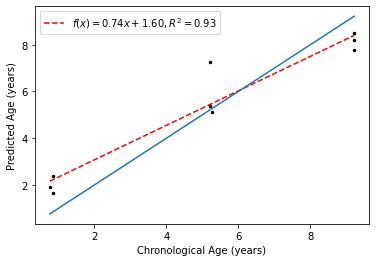

test_pilot_loo PASSED
test_pilot_full PASSED


In [9]:
# Recreates Figure 2D.
# PASS means Figure 2D is recreated precisely as it was in the paper
if test_pilot_loo(PILOT_FNAME,is_print=True):
    print("test_pilot_loo PASSED")
else:
    print("test_pilot_loo FAILED")

# Creates a clock trained on all 9 samples in the dataset
# PASS means Figure 4 is recreated precisely as it was in the original analysis
if test_pilot_full(PILOT_FNAME):
    print("test_pilot_full PASSED")
else:
    print("test_pilot_full FAILED")

In [10]:
# Supplementary Figure 2
# Features shared by the 9 linear models
def supp_fig_2():
    pilot_name_to_age = {1:3364./365, 2:3364./365, 3:3364./365,
                       4:1923./365, 5:1900./365, 6:1900./365,
                       7:307./365, 8:307./365, 9:277./365,}
    pilot_matrix, pilot_sites = preprocess_matrix(PILOT_FNAME, 
                                                  pilot_parse_sample, pilot_name_to_age, None, 110543, '\t')
    L1R = 0.5
    ALPHA = 0.002836935565702689
    MAX_ITER = 8000
    
    #LOO 
    train_colnames = list(pilot_matrix.columns.values)
    n_samples = len(pilot_matrix.columns)
    seq_colnames_left_out = [[i] for i in range(1,n_samples+1) if i in train_colnames]    
    _, saved_coefs = clock_leave_out_general(pilot_matrix, pilot_name_to_age, L1R, ALPHA, MAX_ITER, train_colnames, seq_colnames_left_out, True, False)

    site_to_count = {}
    cgidx_to_site = pilot_sites
    
    frogidx_to_age = {1: 'old', 2: 'old', 3: 'old',
                      4: 'mid', 5: 'mid', 6: 'mid',
                      7: 'yng', 8: 'yng', 9: 'yng',}
    for frog in range(1,9+1):
        for cgindex in range(len(saved_coefs[frog])):
            if saved_coefs[frog][cgindex] != 0. and saved_coefs[frog][cgindex] != -0.:
                site = cgidx_to_site[cgindex]
                list_of_ages = site_to_count.get(site,[])
                list_of_ages.append(frogidx_to_age[frog])
                site_to_count[site] = list_of_ages

    solecounts = {'old':0, 'mid':0, 'yng':0}
    for site, count in sorted(site_to_count.items()):
        nold = len([i for i in count if i == 'old'])
        nmid = len([i for i in count if i == 'mid'])
        nyng = len([i for i in count if i == 'yng'])
        print(f'{site} {len(count)} {nyng} {nmid} {nold} ')
        if count == ['old']:
            solecounts['old'] += 1
        elif count == ['mid']:
            solecounts['mid'] += 1
        elif count == ['yng']:
            solecounts['yng'] += 1

    print('total distinct cgsites identified across all 9 LOO models:',len(site_to_count))

    for i in range(1,9+1):
        print(f'num of cgsites present in {i} models:',len([k for (k,v) in site_to_count.items() if len(v) == i]))

    for frog in range(1,9+1):
        print(f'num sites identified in S{frog} LOO model: {len([i for i in range(len(saved_coefs[frog])) if saved_coefs[frog][i] != 0. and saved_coefs[frog][i] != -0.])}')

    print(f'num of sites only used in the LOO models of a certain age class: {solecounts}')

    sites_in_all_9 = [k for (k,v) in site_to_count.items() if len(v) == 9]
    print(f'sites identified by all 9 models: {sites_in_all_9}')
    
    for num_models in range(1,9+1):
        sites = [k for (k,v) in site_to_count.items() if len(v) == num_models]
        print(f'sites selected_by {num_models} models: {sites}')

supp_fig_2()

Chr10_39383989 3 1 2 0 
Chr1_10308186 1 0 0 1 
Chr1_114942312 1 0 0 1 
Chr1_125895242 1 0 0 1 
Chr1_128224404 1 0 0 1 
Chr1_129739901 1 1 0 0 
Chr1_134254187 5 1 2 2 
Chr1_154900109 1 0 0 1 
Chr1_167139108 1 0 0 1 
Chr1_171864133 1 0 0 1 
Chr1_178837835 1 0 0 1 
Chr1_181284681 2 0 1 1 
Chr1_188187209 1 1 0 0 
Chr1_213041519 2 0 1 1 
Chr1_22750034 1 0 0 1 
Chr1_25725610 9 3 3 3 
Chr1_28023023 9 3 3 3 
Chr1_28032826 1 0 0 1 
Chr1_29114095 1 1 0 0 
Chr1_29116933 1 0 0 1 
Chr1_33015007 3 1 1 1 
Chr1_33161338 1 1 0 0 
Chr1_33162525 1 1 0 0 
Chr1_33192110 4 2 1 1 
Chr1_33192246 8 2 3 3 
Chr1_33193355 2 1 1 0 
Chr1_33193359 6 2 3 1 
Chr1_33194310 9 3 3 3 
Chr1_33194311 6 2 2 2 
Chr1_33194373 9 3 3 3 
Chr1_33194374 9 3 3 3 
Chr1_33194438 1 0 1 0 
Chr1_33198017 5 2 3 0 
Chr1_36672776 8 3 2 3 
Chr1_38764045 1 0 0 1 
Chr1_40770146 8 2 3 3 
Chr1_43350814 5 2 2 1 
Chr1_45537816 9 3 3 3 
Chr1_45999190 2 1 1 0 
Chr1_46490789 9 3 3 3 
Chr1_46646139 1 0 0 1 
Chr1_48923904 1 1 0 0 
Chr1_49486272 8 2 3 3